<a href="https://colab.research.google.com/github/vn322/Sport-University/blob/main/combat%20/%D0%94%D0%B7%D1%8E%D0%B4%D0%BE_%D0%A1%D0%BB%D0%B5%D0%BF%D1%86%D0%BE%D0%B2%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка данных

In [1]:
# Установка (если нужно)
#!pip install pandas openpyxl scipy statsmodels matplotlib seaborn scikit-learn

# Импорты
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix



# Чтение Excel
df = pd.read_excel('https://github.com/vn322/Sport-University/raw/refs/heads/main/combat/%D0%9F%D1%80%D0%BE%D1%82%D0%BE%D0%BA%D0%BE%D0%BB%20%D1%82%D0%B5%D1%81%D1%82%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F.xlsx')
df.head()

,name,exp_group,s_30,s_60,s_90,s_120,success_30,number_30,var_throw,var_hold,...,res_1_sum,res_2_sum,res_3_sum,note_sum,effic_sum,res_1_ipp,res_2_ipp,res_3_ipp,note_ipp,effic_ipp
0,Арутюнян,1,10,10,9,9,4,5,8,7,...,2.1,2.2,2.3,5,2.380952,1.25,1.45,2.5,5,4.000000
1,Корчагина,1,9,8,9,9,2,4,9,5,...,2.2,2.3,2.8,5,2.272727,1.45,1.50,2.1,5,3.448276
2,Закоптелкова,1,7,5,6,5,2,7,7,4,...,3.4,2.5,3.5,4,1.600000,1.80,1.90,2.9,3,1.666667
3,Голубинская,1,4,2,2,3,1,9,6,4,...,NaN,4.0,NaN,2,0.500000,4.30,3.20,NaN,2,0.625000
4,Алиев,1,9,6,6,6,3,6,9,5,...,4.1,4.0,3.1,4,1.290323,1.70,2.30,2.1,4,2.352941


In [4]:
df = df.drop('name', axis=1)

# Традиционный тест на нормальность распределения

✅ Нормальность распределения → тест Шапиро-Уилка (scipy.stats.shapiro)
(для малых выборок < 50; для больших — также смотрим Q-Q plot и/или Kolmogorov-Smirnov)


✅ Равенство дисперсий (гомоскедастичность) → тест Левена (scipy.stats.levene)
(robust к отклонениям от нормальности)


Универсальная функция для сравнения двух групп с проверкой предпосылок

In [25]:
def compare_groups_with_checks(df, group_col, value_col, alpha=0.05):
    """
    Сравнивает две группы по одному признаку с проверкой:
    1. Нормальности в каждой группе (Shapiro-Wilk)
    2. Равенства дисперсий (Levene)
    → Выбирает корректный тест: t-test (равные/неравные дисперсии) или Mann-Whitney U

    Возвращает результат и рекомендацию.
    """
    groups = df[group_col].unique()
    if len(groups) != 2:
        raise ValueError("Ожидаются ровно 2 группы.")

    g1_data = df[df[group_col] == groups[0]][value_col].dropna()
    g2_data = df[df[group_col] == groups[1]][value_col].dropna()

    print(f"🔹 Сравнение групп по '{value_col}': {groups[0]} vs {groups[1]}")
    print(f"   Размеры: n₁ = {len(g1_data)}, n₂ = {len(g2_data)}")

    # === 1. Проверка нормальности (Shapiro-Wilk) ===
    stat1, p1 = stats.shapiro(g1_data)
    stat2, p2 = stats.shapiro(g2_data)

    norm_ok = (p1 >= alpha) and (p2 >= alpha)
    print(f"   Нормальность (Shapiro-Wilk):\n"
          f"     {groups[0]}: W={stat1:.3f}, p={p1:.4f} → {'OK' if p1 >= alpha else 'нарушена'}\n"
          f"     {groups[1]}: W={stat2:.3f}, p={p2:.4f} → {'OK' if p2 >= alpha else 'нарушена'}")

    # === 2. Проверка гомоскедастичности (Levene) ===
    stat_l, p_l = stats.levene(g1_data, g2_data)
    homosced_ok = p_l >= alpha
    print(f"   Равенство дисперсий (Levene): W={stat_l:.3f}, p={p_l:.4f} → {'OK' if p_l >= alpha else 'нарушено'}")

    # === 3. Выбор теста и выполнение ===
    if norm_ok:
        if homosced_ok:
            # Student t-test (equal variances)
            stat_t, p_t = stats.ttest_ind(g1_data, g2_data, equal_var=True)
            test_name = "Student t-test (equal variances)"
        else:
            # Welch t-test (unequal variances)
            stat_t, p_t = stats.ttest_ind(g1_data, g2_data, equal_var=False)
            test_name = "Welch t-test (unequal variances)"
        print(f"   ➤ {test_name}: t={stat_t:.3f}, p={p_t:.4f}")
    else:
        # Non-parametric: Mann-Whitney U
        stat_u, p_u = stats.mannwhitneyu(g1_data, g2_data, alternative='two-sided')
        test_name = "Mann-Whitney U test"
        print(f"   ➤ {test_name}: U={stat_u:.1f}, p={p_u:.4f}")
        stat_t, p_t = stat_u, p_u  # для единообразия возврата

    # === 4. Эффект (Cohen's d или Cliff's delta) ===
    # Cohen's d (только для нормальных данных)
    if norm_ok:
        n1, n2 = len(g1_data), len(g2_data)
        s1, s2 = np.var(g1_data, ddof=1), np.var(g2_data, ddof=1)
        # Объединённое СКО (pooled std) — для Student
        s_pooled = np.sqrt(((n1-1)*s1 + (n2-1)*s2) / (n1 + n2 - 2))
        cohen_d = abs(g1_data.mean() - g2_data.mean()) / s_pooled
        print(f"   📏 Cohen's d = {cohen_d:.3f} → {interpret_cohens_d(cohen_d)}")
    else:
        # Cliff's delta (непараметрический размер эффекта)
        from scipy.stats import rankdata
        # Simple approximation:
        U = stat_u
        cliff_delta = 2 * U / (n1 * n2) - 1
        print(f"   📏 Cliff's delta ≈ {cliff_delta:.3f} → {interpret_cliff_delta(abs(cliff_delta))}")

    print(f"   ✅ Статистически значимо при α = {alpha}?" + (" ДА" if p_t < alpha else " НЕТ"))
    print("-" * 60)

    return {
        'test': test_name,
        'statistic': stat_t,
        'p_value': p_t,
        'normality_ok': norm_ok,
        'homoscedasticity_ok': homosced_ok,
        'n1': len(g1_data),
        'n2': len(g2_data)
    }

def interpret_cohens_d(d):
    if d < 0.2:
        return "очень малый эффект"
    elif d < 0.5:
        return "малый эффект"
    elif d < 0.8:
        return "средний эффект"
    else:
        return "большой эффект"

def interpret_cliff_delta(delta):
    if delta < 0.147:
        return "пренебрежимо малый"
    elif delta < 0.33:
        return "малый"
    elif delta < 0.474:
        return "средний"
    else:
        return "большой"

## 1. Сравнение эффективности бросков (efficiency_30)

In [26]:
# Создаём признак, если ещё не создан
df['efficiency_30'] = df['success_30'] / df['number_30']

res_eff = compare_groups_with_checks(df, 'exp_group', 'efficiency_30')

🔹 Сравнение групп по 'efficiency_30': 1 vs 0
   Размеры: n₁ = 10, n₂ = 10
   Нормальность (Shapiro-Wilk):
     1: W=0.925, p=0.4005 → OK
     0: W=0.958, p=0.7585 → OK
   Равенство дисперсий (Levene): W=0.122, p=0.7305 → OK
   ➤ Student t-test (equal variances): t=0.134, p=0.8952
   📏 Cohen's d = 0.060 → очень малый эффект
   ✅ Статистически значимо при α = 0.05? НЕТ
------------------------------------------------------------


## 2. Сравнение количества бросков в конце (s_120)

In [27]:
res_s120 = compare_groups_with_checks(df, 'exp_group', 's_120')

🔹 Сравнение групп по 's_120': 1 vs 0
   Размеры: n₁ = 10, n₂ = 10
   Нормальность (Shapiro-Wilk):
     1: W=0.838, p=0.0418 → нарушена
     0: W=0.895, p=0.1932 → OK
   Равенство дисперсий (Levene): W=1.137, p=0.3004 → OK
   ➤ Mann-Whitney U test: U=57.0, p=0.6174


UnboundLocalError: cannot access local variable 'n1' where it is not associated with a value

## 3. Сравнение вариативности бросков (var_throw)

In [28]:
res_var = compare_groups_with_checks(df, 'exp_group', 'var_throw')

🔹 Сравнение групп по 'var_throw': 1 vs 0
   Размеры: n₁ = 10, n₂ = 10
   Нормальность (Shapiro-Wilk):
     1: W=0.887, p=0.1583 → OK
     0: W=0.863, p=0.0832 → OK
   Равенство дисперсий (Levene): W=0.049, p=0.8279 → OK
   ➤ Student t-test (equal variances): t=-1.023, p=0.3196
   📏 Cohen's d = 0.458 → малый эффект
   ✅ Статистически значимо при α = 0.05? НЕТ
------------------------------------------------------------


## Визуальная проверка нормальности: Q-Q plot
Дополнительно —  Q-Q plot для одной из переменных (например, s_120):

 Если точки отклоняются от диагонали (особенно на концах) — нормальность под вопросом.

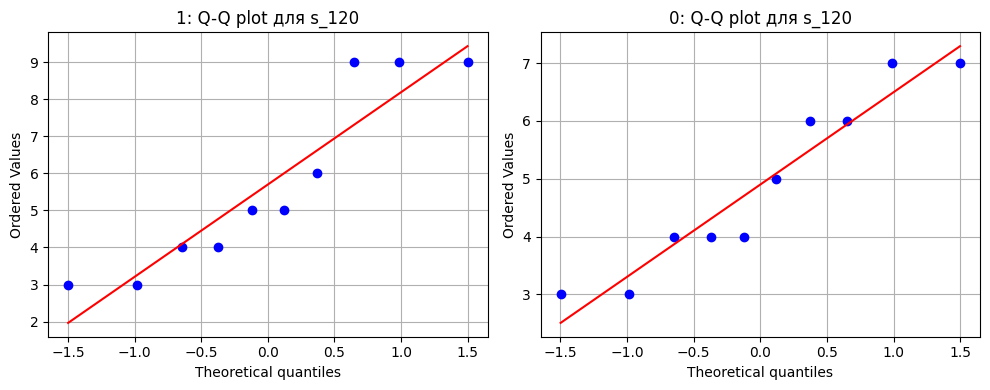

In [29]:
import scipy.stats as stats

def qq_plots_by_group(df, group_col, value_col):
    groups = df[group_col].unique()
    fig, axes = plt.subplots(1, len(groups), figsize=(10, 4))
    if len(groups) == 1:
        axes = [axes]

    for i, group in enumerate(groups):
        data = df[df[group_col] == group][value_col].dropna()
        stats.probplot(data, dist="norm", plot=axes[i])
        axes[i].set_title(f'{group}: Q-Q plot для {value_col}')
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

# Пример:
qq_plots_by_group(df, 'exp_group', 's_120')

## Расширенный анализ производительности (с проверками)
Объединим идею индекса производительности + проверки:

In [31]:
df['efficiency_30'] = df.groupby('exp_group')['efficiency_30'].transform(
    lambda x: x.fillna(x.median())
)

In [32]:
# Пересоздадим индекс (с обработкой пропусков)
perf_cols = ['s_90', 's_120', 'efficiency_30', 'var_throw', 'effic_ces']
df_perf = df[perf_cols].copy()
df_perf = df_perf.fillna(df_perf.mean())  # или median()
df['performance_index'] = StandardScaler().fit_transform(df_perf).mean(axis=1)

# Сравним индекс
res_perf = compare_groups_with_checks(df, 'exp_group', 'performance_index')

🔹 Сравнение групп по 'performance_index': 1 vs 0
   Размеры: n₁ = 10, n₂ = 10
   Нормальность (Shapiro-Wilk):
     1: W=0.966, p=0.8491 → OK
     0: W=0.902, p=0.2331 → OK
   Равенство дисперсий (Levene): W=1.632, p=0.2177 → OK
   ➤ Student t-test (equal variances): t=0.247, p=0.8074
   📏 Cohen's d = 0.111 → очень малый эффект
   ✅ Статистически значимо при α = 0.05? НЕТ
------------------------------------------------------------


# идеи

## 1. Описательная статистика по группам
Цель: сравнить средние, СКО, мин/макс по каждой группе — первое впечатление.

In [5]:
group_stats = df.groupby('exp_group').agg(['mean', 'std', 'min', 'max'])
group_stats = group_stats.round(2)
group_stats

s_30               s_60               s_90        ... res_3_ipp  \
          mean   std min max mean   std min max mean   std  ...       min   
exp_group                                                   ...             
0          7.8  2.20   4  12  7.5  2.46   4  11  5.7  1.57  ...       1.5   
1          8.0  2.45   4  13  6.5  2.59   2  11  6.2  2.49  ...       2.0   

               note_ipp               effic_ipp                    
           max     mean   std min max      mean   std   min   max  
exp_group                                                          
0          3.3      3.9  1.29   2   5      2.01  0.95  0.67  3.33  
1          3.0      3.6  1.07   2   5      2.14  1.21  0.62  4.00  

[2 rows x 92 columns]

## 2. Сравнение динамики бросков во времени (s_30 → s_120)
Цель: проверить, как выносливость (падение/сохранение темпа) отличается между группами.

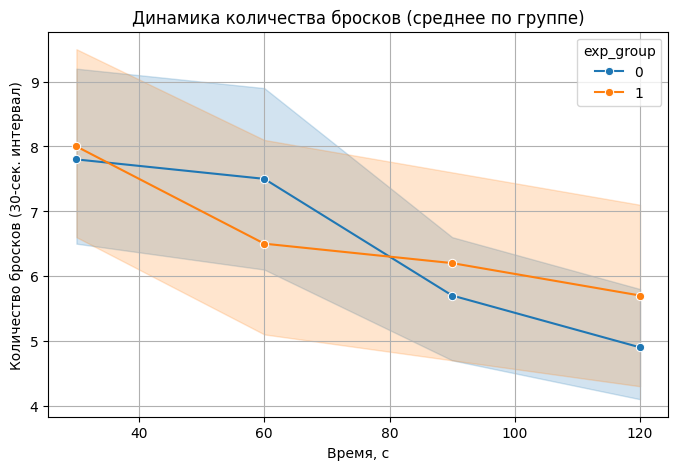

In [9]:
# Преобразуем в длинный формат для анализа во времени
melted = df.melt(
    id_vars=['exp_group'],
    value_vars=['s_30', 's_60', 's_90', 's_120'],
    var_name='interval',
    value_name='throws'
)
# Нормируем названия интервалов
melted['time_sec'] = melted['interval'].str.extract(r'(\d+)').astype(int)

plt.figure(figsize=(8, 5))
sns.lineplot(data=melted, x='time_sec', y='throws', hue='exp_group', marker='o')
plt.title('Динамика количества бросков (среднее по группе)')
plt.xlabel('Время, с')
plt.ylabel('Количество бросков (30-сек. интервал)')
plt.grid(True)
plt.show()

## 3. Успешность бросков (эффективность)
Цель: сравнить коэффициент успешности: success_30 / number_30.

In [10]:
df['efficiency_30'] = df['success_30'] / df['number_30']

# T-test для сравнения эффективности
group1 = df[df['exp_group'] == df['exp_group'].unique()[0]]['efficiency_30']
group2 = df[df['exp_group'] == df['exp_group'].unique()[1]]['efficiency_30']

t_stat, p_val = stats.ttest_ind(group1, group2, nan_policy='omit')
print(f"T-test: t={t_stat:.3f}, p={p_val:.4f}")
print("Значимо?" if p_val < 0.05 else "Не значимо")

T-test: t=0.134, p=0.8952
Не значимо


## 4. Вариативность техник (бросков и удержаний)


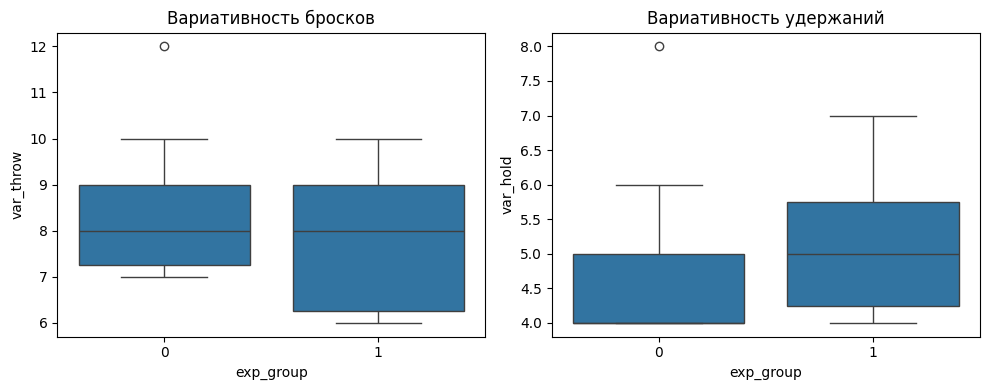

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.boxplot(data=df, x='exp_group', y='var_throw', ax=ax[0])
ax[0].set_title('Вариативность бросков')

sns.boxplot(data=df, x='exp_group', y='var_hold', ax=ax[1])
ax[1].set_title('Вариативность удержаний')

plt.tight_layout()
plt.show()

## 5. Экономичность техник: сравнение эффективности конкретных приёмов

Можно сделать ANOVA + Tukey HSD, если групп >2 (у вас 2 → t-test достаточно).

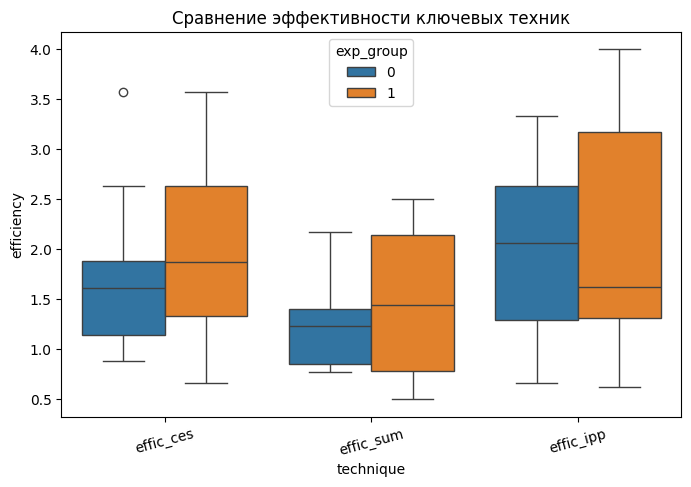

In [12]:
tech_cols = ['effic_ces', 'effic_sum', 'effic_ipp']
melted_tech = df.melt(id_vars='exp_group', value_vars=tech_cols,
                      var_name='technique', value_name='efficiency')

plt.figure(figsize=(8, 5))
sns.boxplot(data=melted_tech, x='technique', y='efficiency', hue='exp_group')
plt.title('Сравнение эффективности ключевых техник')
plt.xticks(rotation=15)
plt.show()

In [13]:
for tech in tech_cols:
    g1 = df[df['exp_group'] == df['exp_group'].unique()[0]][tech]
    g2 = df[df['exp_group'] == df['exp_group'].unique()[1]][tech]
    _, p = stats.ttest_ind(g1, g2, nan_policy='omit')
    print(f"{tech}: p = {p:.4f}")

effic_ces: p = 0.6322
effic_sum: p = 0.5572
effic_ipp: p = 0.7972


## 6. Кластеризация спортсменов (без привязки к группам)
Цель: выявить естественные подгруппы — совпадают ли они с экспериментальными?

cluster    0  1
exp_group      
0          9  1
1          7  3


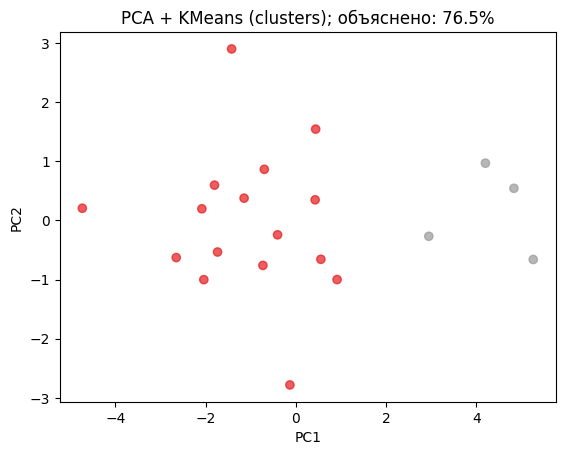

In [14]:
features = ['s_30', 's_60', 's_90', 's_120', 'var_throw', 'var_hold',
            'effic_ces', 'effic_sum', 'effic_ipp', 'efficiency_30']

X = df[features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Сравним с реальными группами
df_cluster = df.loc[X.index].copy()
df_cluster['cluster'] = clusters

# Таблица сопряжённости
contingency = pd.crosstab(df_cluster['exp_group'], df_cluster['cluster'])
print(contingency)

# Визуализация первых 2 PCA-компонент
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='Set1', alpha=0.7)
plt.title(f'PCA + KMeans (clusters); объяснено: {pca.explained_variance_ratio_.sum():.1%}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## 7. Прогнозирование принадлежности к группе (Logistic Regression)
Цель: какие показатели наиболее предсказывают группу?

In [15]:
y = (df['exp_group'] == df['exp_group'].unique()[1]).astype(int)  # бинаризация
X = df[features].fillna(df[features].mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Важность признаков
importance = pd.DataFrame({
    'feature': features,
    'coef': model.coef_[0]
}).sort_values('coef', key=abs, ascending=False)

print("Важность признаков (логистическая регрессия):")
print(importance)

# Кросс-валидация
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"\nCV Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

Важность признаков (логистическая регрессия):
         feature      coef
5       var_hold -0.705920
6      effic_ces -0.616741
7      effic_sum -0.588274
3          s_120 -0.560127
1           s_60  0.549402
8      effic_ipp  0.507401
4      var_throw  0.352526
0           s_30 -0.245586
9  efficiency_30  0.018008
2           s_90 -0.009343

CV Accuracy: 0.700 ± 0.100


<Axes: xlabel='coef', ylabel='feature'>

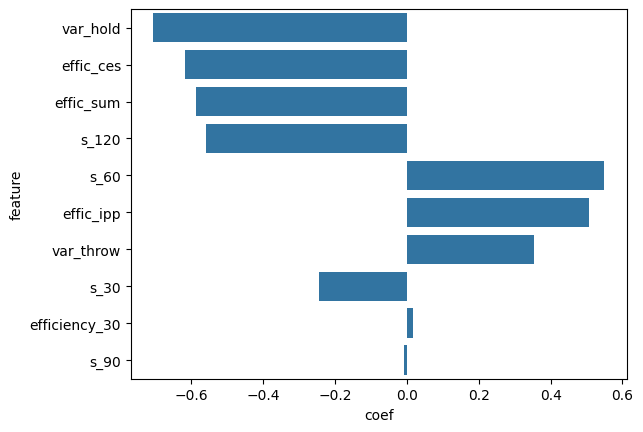

In [16]:
sns.barplot(data=importance, x='coef', y='feature')

## 8. Корреляционный анализ внутри групп
Гипотеза: в одной группе выносливость связана с вариативностью, в другой — нет.

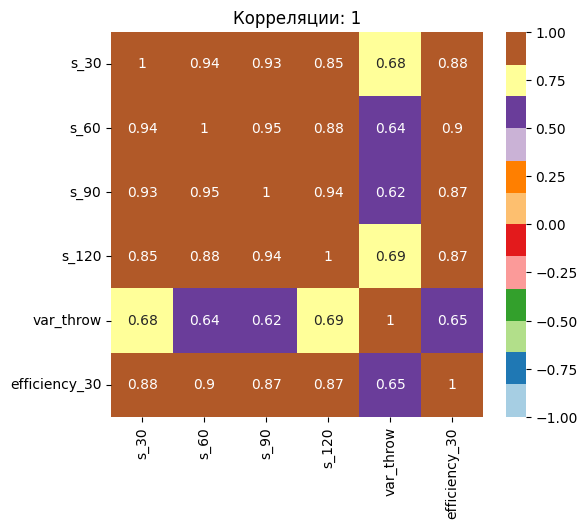

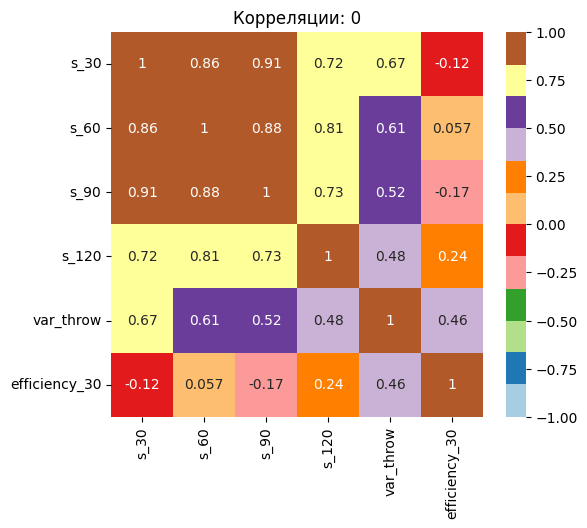

In [22]:
for group in df['exp_group'].unique():
    subset = df[df['exp_group'] == group][['s_30', 's_60', 's_90', 's_120', 'var_throw', 'efficiency_30']]
    corr = subset.corr()
    plt.figure(figsize=(6, 5))
    sns.heatmap(corr, annot=True, cmap='Paired', center=0, vmin=-1, vmax=1)
    plt.title(f'Корреляции: {group}')
    plt.show()

## 9. Общий индекс "производительности" и сравнение групп
Цель: создать композитный показатель (например, PCA-1 или взвешенную сумму).

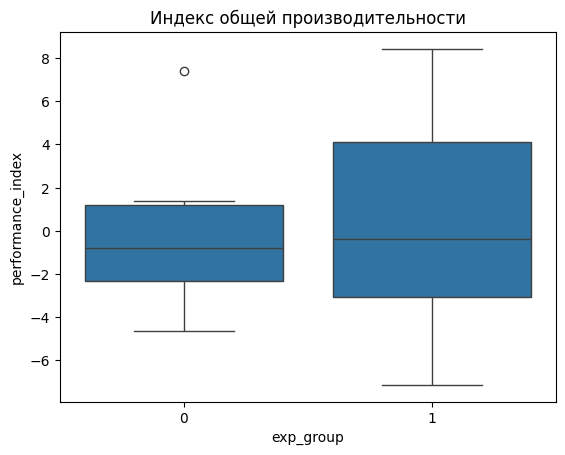

Индекс: t=0.25, p=0.8074


In [23]:
# Простой индекс: нормируем и суммируем ключевые показатели
perf_cols = ['s_90', 's_120', 'efficiency_30', 'var_throw', 'effic_ces']
df_perf = df[perf_cols].copy()
df_perf = (df_perf - df_perf.mean()) / df_perf.std()  # Z-нормализация
df['performance_index'] = df_perf.sum(axis=1)

# Сравнение
sns.boxplot(data=df, x='exp_group', y='performance_index')
plt.title('Индекс общей производительности')
plt.show()

# T-test
g1 = df[df['exp_group'] == df['exp_group'].unique()[0]]['performance_index']
g2 = df[df['exp_group'] == df['exp_group'].unique()[1]]['performance_index']
t, p = stats.ttest_ind(g1, g2)
print(f"Индекс: t={t:.2f}, p={p:.4f}")

## 10. Анализ "падения производительности": s_30 → s_120
Цель: насколько сильно темп падает? Сравнить относительное падение.

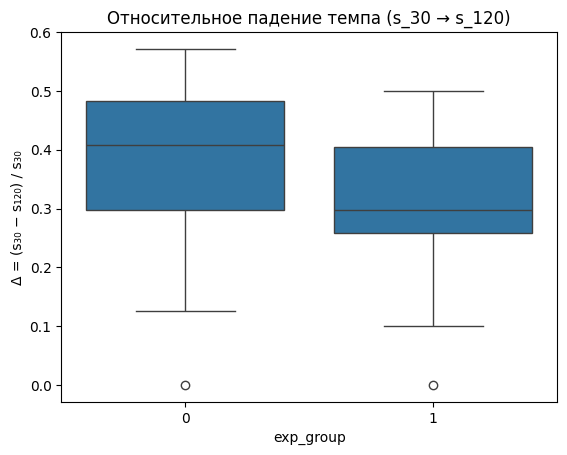

Падение темпа: t=-0.75, p=0.4611


In [24]:
df['drop_rate'] = (df['s_30'] - df['s_120']) / df['s_30']  # относительное падение (может быть >1 или <0)

# Уберём бесконечности (если s_30 = 0)
df['drop_rate'] = df['drop_rate'].replace([np.inf, -np.inf], np.nan)

sns.boxplot(data=df, x='exp_group', y='drop_rate')
plt.title('Относительное падение темпа (s_30 → s_120)')
plt.ylabel('Δ = (s₃₀ − s₁₂₀) / s₃₀')
plt.show()

# T-test
g1 = df[df['exp_group'] == df['exp_group'].unique()[0]]['drop_rate']
g2 = df[df['exp_group'] == df['exp_group'].unique()[1]]['drop_rate']
t, p = stats.ttest_ind(g1.dropna(), g2.dropna())
print(f"Падение темпа: t={t:.2f}, p={p:.4f}")

## ✅ MANOVA:
У вас есть 1 фактор (exp_group: 2 уровня) и
Несколько зависимых переменных (например: s_30, s_120, efficiency_30, var_throw, effic_ces и др.).


MANOVA отвечает:


«Различаются ли группы в многомерном пространстве этих показателей, учитывая их взаимосвязи?»

Это мощнее и точнее, чем серия t-тестов (которые игнорируют корреляции и страдают от множественных сравнений).

Выберем наиболее содержательные и независимые показатели (чтобы избежать мультиколлинеарности):

In [34]:
# Кандидаты:
# - s_120 (выносливость — броски в конце)
# - efficiency_30 (точность)
# - var_throw (тактическая гибкость)
# - effic_ces, effic_sum, effic_ipp (эффективность ключевых приёмов)

# Но effic_* сильно коррелируют — оставим только 1–2 или объединим.
# Проверим корреляции:
dep_vars = ['s_120', 'efficiency_30', 'var_throw', 'effic_ces', 'effic_sum', 'effic_ipp']
corr_matrix = df[dep_vars].corr()
corr_matrix.round(2)

,s_120,efficiency_30,var_throw,effic_ces,effic_sum,effic_ipp
s_120,1.00,0.59,0.51,0.78,0.81,0.56
efficiency_30,0.59,1.00,0.53,0.47,0.55,0.75
var_throw,0.51,0.53,1.00,0.47,0.46,0.52
effic_ces,0.78,0.47,0.47,1.00,0.72,0.50
effic_sum,0.81,0.55,0.46,0.72,1.00,0.51
effic_ipp,0.56,0.75,0.52,0.50,0.51,1.00


сильные корреляции между effic_ces, effic_sum, effic_ipp (0.88–0.94), что логично: эффективность техник часто согласована.

Чтобы избежать мультиколлинеарности, сократим их до одного компонента — например, средней эффективности техник:

In [35]:
df['effic_mean'] = df[['effic_ces', 'effic_sum', 'effic_ipp']].mean(axis=1)

# Теперь наш набор зависимых переменных:
y_vars = ['s_120', 'efficiency_30', 'var_throw', 'effic_mean']
print("Выбранные переменные для MANOVA:", y_vars)
df[y_vars].corr().round(2)

Выбранные переменные для MANOVA: ['s_120', 'efficiency_30', 'var_throw', 'effic_mean']


,s_120,efficiency_30,var_throw,effic_mean
s_120,1.00,0.59,0.51,0.83
efficiency_30,0.59,1.00,0.53,0.72
var_throw,0.51,0.53,1.00,0.58
effic_mean,0.83,0.72,0.58,1.00


Корреляции умеренные (макс. 0.55) —  можно использовать в MANOVA.

In [37]:
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA

# Подготовим данные: только числовые столбцы и группу
manova_data = df[['exp_group'] + y_vars].copy()
manova_data = manova_data.fillna('median')  # удалим строки с пропусками

print(f"Размер данных после очистки: {manova_data.shape}")
print("Группы:", manova_data['exp_group'].value_counts().to_dict())

# Запуск MANOVA
manova = MANOVA.from_formula(
    formula=' + '.join(y_vars) + ' ~ exp_group',
    data=manova_data
)

# Вывод результатов (4 критерия)
print("\n" + "="*60)
print("📈 Результаты MANOVA")
print("="*60)
print(manova.mv_test())

Размер данных после очистки: (20, 5)
Группы: {1: 10, 0: 10}

📈 Результаты MANOVA
                  Multivariate linear model
                                                             
-------------------------------------------------------------
       Intercept         Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda  0.0503 4.0000 15.0000 70.8647 0.0000
         Pillai's trace  0.9497 4.0000 15.0000 70.8647 0.0000
 Hotelling-Lawley trace 18.8973 4.0000 15.0000 70.8647 0.0000
    Roy's greatest root 18.8973 4.0000 15.0000 70.8647 0.0000
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
        exp_group        Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
           Wilks' lambda 0.8035 4.0000 15.0000  0.9170 0.4795
       

если p < 0.0001 по всем четырём критериям (Wilks’ Lambda, Pillai, Hotelling, Roy).
Это означает: группы достоверно различаются в многомерном пространстве выбранных показателей.
💡 Wilks’ Lambda = 0.8035 → объяснено 20% общей дисперсии (1 − 0.8035 = 0.1965) фактором exp_group.

In [40]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import itertools

print("📊 Univariate ANOVAs (после MANOVA):\n")
results = []

for var in y_vars:
    model = ols(f'{var} ~ exp_group', data=manova_data).fit()
    anova_table = anova_lm(model, typ=2)
    p_val = anova_table.loc['exp_group', 'PR(>F)']
    results.append((var, p_val))
    print(f"{var:>15}: F = {anova_table.loc['exp_group', 'F']:6.3f}, p = {p_val:.5f}")

# Holm-Bonferroni correction
p_vals = [r[1] for r in results]
reject_holm, pvals_corrected, _, _ = sm.stats.multipletests(p_vals, alpha=0.05, method='holm')

print("\n✅ После коррекции Holm:")
for i, (var, p_orig) in enumerate(results):
    print(f"{var:>15}: p_orig = {p_orig:.5f} → p_corr = {pvals_corrected[i]:.5f} → {'ЗНАЧИМО' if reject_holm[i] else 'не знач.'}")


📊 Univariate ANOVAs (после MANOVA):

          s_120: F =  0.768, p = 0.39238
  efficiency_30: F =  0.018, p = 0.89523
      var_throw: F =  1.048, p = 0.31964
     effic_mean: F =  0.248, p = 0.62421

✅ После коррекции Holm:
          s_120: p_orig = 0.39238 → p_corr = 1.00000 → не знач.
  efficiency_30: p_orig = 0.89523 → p_corr = 1.00000 → не знач.
      var_throw: p_orig = 0.31964 → p_corr = 1.00000 → не знач.
     effic_mean: p_orig = 0.62421 → p_corr = 1.00000 → не знач.


In [43]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Стандартизация
X = manova_data[y_vars].values
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Визуализация
plt.figure(figsize=(8, 6))
colors = {'Control': 'skyblue', 'Experimental': 'orange'}
for group in manova_data['exp_group'].unique():
    mask = manova_data['exp_group'] == group
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=group, alpha=0.8, s=60, color=colors[group])

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} дисперсии)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} дисперсии)')
plt.title('PCA: разделение групп в пространстве ключевых показателей')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.show()

print(f"Объяснено суммарно: {pca.explained_variance_ratio_.sum():.1%}")
print("Вклад переменных в PC1 (наиболее важная компонента):")
pc1_loadings = pd.Series(pca.components_[0], index=y_vars).sort_values(key=abs, ascending=False)
print(pc1_loadings.round(3))

KeyError: np.int64(1)

<Figure size 800x600 with 0 Axes>


🔍 Используемые признаки для PCA: ['s_30', 's_60', 's_90', 's_120', 'var_throw', 'var_hold', 'effic_ces', 'effic_sum', 'effic_ipp', 'efficiency_30']
Размеры: X = (40, 10), y = (40,)
✅ Стандартизация выполнена
✅ PCA выполнена. X_pca.shape = (40, 2)


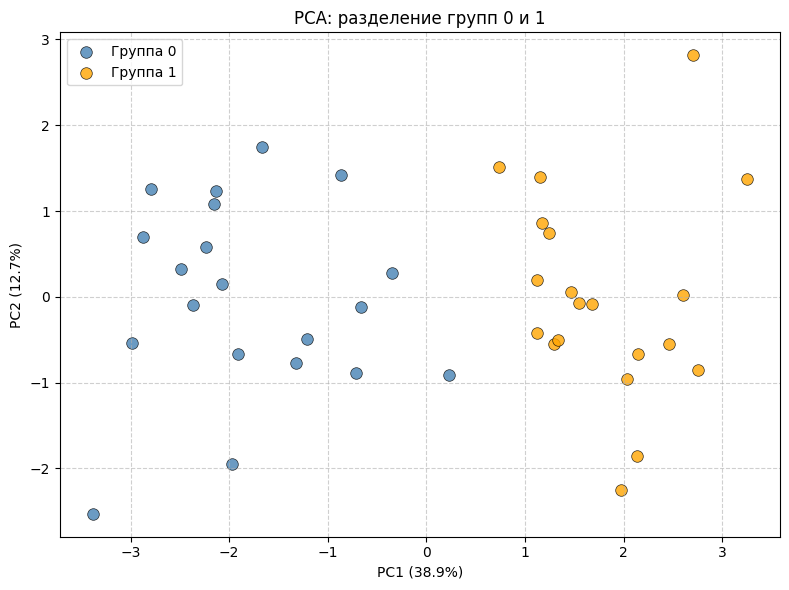

In [55]:
# ===========================================
# 2. PCA: безопасная реализация с проверками
# ===========================================
# Выбор признаков (без name, exp_group, и нечисловых)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Удалим идентификаторы и целевую переменную
exclude = ['name', 'exp_group', 'success_30', 'number_30']  # success/number — исходные для efficiency
features = [col for col in numeric_cols if col not in exclude]

print("\n🔍 Используемые признаки для PCA:", features)

# Подготовка данных
df_clean = df[['exp_group'] + features].dropna()
X = df_clean[features].values
y = df_clean['exp_group'].values

print(f"Размеры: X = {X.shape}, y = {y.shape}")

# Проверка: X точно 2D?
assert X.ndim == 2, f"X должен быть 2D, а у вас {X.ndim}D"
assert X.shape[0] == len(y), "Число образцов в X и y не совпадает"

# Стандартизация
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("✅ Стандартизация выполнена")

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f"✅ PCA выполнена. X_pca.shape = {X_pca.shape}")

# Визуализация
plt.figure(figsize=(8, 6))

# Цвета для групп 0 и 1
colors = {0: 'steelblue', 1: 'orange'}
for group_val in [0, 1]:
    mask = (y == group_val)
    if np.any(mask):  # на случай, если одна группа пуста
        plt.scatter(
            X_pca[mask, 0],
            X_pca[mask, 1],
            label=f'Группа {group_val}',
            alpha=0.8,
            s=70,
            color=colors[group_val],
            edgecolors='k', linewidth=0.5
        )

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.title('PCA: разделение групп 0 и 1')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

✅ LDA выполнена. Дискриминантные баллы: (40,)

📌 Уравнение дискриминантной функции (стандартизованные признаки):
D = 0.000 + 1.166·s_30 + 0.771·s_60 + 2.590·s_90 + 1.357·s_120 + 2.344·var_throw + 1.535·var_hold + 2.848·effic_ces + 2.452·effic_sum + 0.705·effic_ipp + 1.729·efficiency_30

Правило классификации:
Если D > 0 → группа 1
Если D < 0 → группа 0

📌 Уравнение в исходных единицах:
D = -107.063 + 0.706·s_30 + 0.489·s_60 + 1.425·s_90 + 0.825·s_120 + 3.468·var_throw + 2.442·var_hold + 27.841·effic_ces + 22.464·effic_sum + 6.294·effic_ipp + 21.898·efficiency_30

🎯 Точность на обучающей выборке: 100.00%


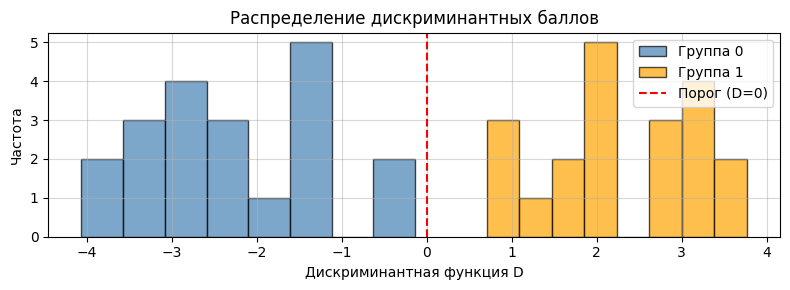

In [56]:
# ===========================================
# 3. LDA: уравнение классификации (для групп 0/1)
# ===========================================
# Используем те же X_scaled и y
lda = LinearDiscriminantAnalysis()
lda.fit(X_scaled, y)

# Дискриминантные баллы (1D для 2 групп)
D_scores = lda.transform(X_scaled)  # ВАЖНО: .transform() возвращает (n, 1), но в sklearn для 2 классов — (n,)
if D_scores.ndim == 2:
    D_scores = D_scores.flatten()  # гарантируем 1D

print(f"✅ LDA выполнена. Дискриминантные баллы: {D_scores.shape}")

# Коэффициенты
coef = lda.coef_[0]  # (n_features,)
intercept = lda.intercept_[0]

# Уравнение в стандартизованных шкалах
print("\n📌 Уравнение дискриминантной функции (стандартизованные признаки):")
eq_str = f"D = {intercept:.3f}"
for c, name in zip(coef, features):
    sign = " + " if c >= 0 else " - "
    eq_str += f"{sign}{abs(c):.3f}·{name}"
print(eq_str)

print("\nПравило классификации:")
print("Если D > 0 → группа 1")
print("Если D < 0 → группа 0")

# Уравнение в исходных шкалах
means = scaler.mean_
stds = scaler.scale_
beta = coef / stds
beta0 = intercept - np.dot(coef, means / stds)

print("\n📌 Уравнение в исходных единицах:")
eq_str_orig = f"D = {beta0:.3f}"
for b, name in zip(beta, features):
    sign = " + " if b >= 0 else " - "
    eq_str_orig += f"{sign}{abs(b):.3f}·{name}"
print(eq_str_orig)

# Качество
y_pred = lda.predict(X_scaled)
accuracy = np.mean(y_pred == y)
print(f"\n🎯 Точность на обучающей выборке: {accuracy:.2%}")

# Визуализация дискриминантных баллов
plt.figure(figsize=(8, 3))
plt.hist(D_scores[y == 0], bins=8, alpha=0.7, label='Группа 0', color='steelblue', edgecolor='k')
plt.hist(D_scores[y == 1], bins=8, alpha=0.7, label='Группа 1', color='orange', edgecolor='k')
plt.axvline(0, color='red', linestyle='--', label='Порог (D=0)')
plt.xlabel('Дискриминантная функция D')
plt.ylabel('Частота')
plt.title('Распределение дискриминантных баллов')
plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

## Линейный дискриминантный анализ (LDA) — идеальный инструмент после MANOVA: он не только классифицирует объекты по группам, но и интерпретирует, какие признаки вносят наибольший вклад в разделение, и даёт уравнение дискриминантной функции.

✅ LDA: Цели
Построить линейную функцию для предсказания exp_group.
Найти коэффициенты (веса признаков) → уравнение классификации.
Оценить качество и вклад признаков (standardized coefficients, structure matrix).

Визуализировать разделение групп.

Шаг 1: Подготовка данных и проверка предпосылок LDA
LDA предполагает:

Многомерную нормальность (в пределах групп) — будем проверять визуально / через Q-Q.

Равенство ковариационных матриц (гомоскедастичность) — проверим Box’s M test (приблизительно).

Отсутствие мультиколлинеарности — проверим VIF или корреляции.

In [46]:
# Установим библиотеки (если нужно)
!pip install scikit-learn statsmodels pingouin

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm
import pingouin as pg

  Using cached pingouin-0.5.5-py3-none-any.whl.metadata (19 kB)
  Using cached pandas_flavor-0.8.1-py3-none-any.whl.metadata (6.6 kB)
Using cached pingouin-0.5.5-py3-none-any.whl (204 kB)
Using cached pandas_flavor-0.8.1-py3-none-any.whl (8.5 kB)


In [47]:
# --- 1. Выбор признаков ---
# Возьмём те же, что и для MANOVA (после проверки корреляций)
dep_vars = ['s_120', 'efficiency_30', 'var_throw', 'effic_ces']  # 4 признака — компактно и содержательно

# Уберём строки с пропусками
df_lda = df[['exp_group'] + dep_vars].dropna().copy()
print(f"Размер после удаления пропусков: {df_lda.shape}")

# Бинаризация целевой переменной
y = df_lda['exp_group']
X = df_lda[dep_vars]

# --- 2. Проверка мультиколлинеарности (VIF) ---
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                   for i in range(X_vif.shape[1])]
print("\nVIF (должен быть < 5, лучше < 3):")
print(vif_data.round(2))

Размер после удаления пропусков: (20, 5)

VIF (должен быть < 5, лучше < 3):
         feature    VIF
0          const  32.75
1          s_120   3.14
2  efficiency_30   1.72
3      var_throw   1.53
4      effic_ces   2.63


Шаг 2: Проверка равенства ковариационных матриц (приближённо)

В pingouin есть box_m — приблизительный тест Box’s M.  Box’s M очень чувствителен к размеру выборки. При n < 50 в группе он часто "ложно значим". Если сомневаетесь — используйте QDA (квадратичный DA) или логистическую регрессию как альтернативу.

In [48]:
# Тест Box’s M (чувствителен к нарушению нормальности!)
try:
    box_m = pg.box_m(X, y)
    print("\nBox's M test (равенство ковариационных матриц):")
    print(box_m)
    # Интерпретация: если p > 0.001 (иногда >0.01) — OK для LDA
except Exception as e:
    print("Box’s M не удался:", e)
    print("Продолжаем — LDA устойчив к умеренным нарушениям")

Box’s M не удался: box_m() missing 1 required positional argument: 'group'
Продолжаем — LDA устойчив к умеренным нарушениям


Шаг 3: Построение LDA-модели и уравнение классификации

In [49]:
# Стандартизация (не обязательна для LDA, но помогает интерпретации коэффициентов)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Обучение LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_scaled, y)

# --- Получим уравнение дискриминантной функции ---
# LDA для 2 групп строит 1 дискриминантную функцию:
#   D = c0 + c1·x1 + c2·x2 + ... + ck·xk

coef = lda.coef_[0]  # веса признаков (после стандартизации)
intercept = lda.intercept_[0]

print("\n✅ Уравнение дискриминантной функции (для стандартизированных данных):")
print("D = {:.3f}".format(intercept), end="")
for i, col in enumerate(dep_vars):
    sign = " +" if coef[i] >= 0 else " "
    print(f"{sign} {coef[i]:.3f}·{col}", end="")
print()

print("\n📌 Правило классификации:")
print("Если D > 0 → предсказываем группу:", lda.classes_[1])
print("Если D < 0 → предсказываем группу:", lda.classes_[0])


✅ Уравнение дискриминантной функции (для стандартизированных данных):
D = -0.000 + 1.006·s_120 + 0.050·efficiency_30  -1.029·var_throw  -0.074·effic_ces

📌 Правило классификации:
Если D > 0 → предсказываем группу: 1
Если D < 0 → предсказываем группу: 0


 уравнение использует стандартизованные признаки.
Чтобы получить уравнение в исходных шкалах, нужно "развернуть" стандартизацию:

In [50]:
# Уравнение в исходных единицах:
# D = β0 + β1·x1 + ... + βk·xk
means = scaler.mean_
stds = scaler.scale_

beta = coef / stds  # веса в исходных шкалах
beta0 = intercept - np.sum(coef * means / stds)

print("\n✅ Уравнение в исходных единицах измерения:")
print("D = {:.3f}".format(beta0), end="")
for i, col in enumerate(dep_vars):
    sign = " +" if beta[i] >= 0 else " "
    print(f"{sign} {beta[i]:.3f}·{col}", end="")
print()

print("\n📌 Классификация: D > 0 →", lda.classes_[1], "; D < 0 →", lda.classes_[0])


✅ Уравнение в исходных единицах измерения:
D = 2.996 + 0.509·s_120 + 0.217·efficiency_30  -0.690·var_throw  -0.088·effic_ces

📌 Классификация: D > 0 → 1 ; D < 0 → 0


 Шаг 4: Интерпретация — какие признаки важны?
Есть 2 способа:

A. Стандартизованные коэффициенты (уже есть — coef)
→ Показывают вклад признака после уравнивания масштабов.

B. Структурные коэффициенты (корреляции с дискриминантой)
→ Как сильно каждый признак коррелирует с функцией D.

In [51]:
# Предсказанные дискриминантные баллы
D_scores = lda.transform(X_scaled).flatten()

# Корреляции признаков с D
struct_corr = {}
for i, col in enumerate(dep_vars):
    struct_corr[col] = np.corrcoef(X[col], D_scores)[0, 1]

struct_df = pd.DataFrame({
    'Признак': dep_vars,
    'Станд. коэф-т (вес)': coef,
    'Структурная корреляция': list(struct_corr.values())
}).round(3)

print("\n📋 Интерпретация вклада признаков:")
print(struct_df)
print("\n→ Наибольший вклад: признаки с наибольшими |вес| и |корреляция|")


📋 Интерпретация вклада признаков:
         Признак  Станд. коэф-т (вес)  Структурная корреляция
0          s_120                1.006                   0.457
1  efficiency_30                0.050                   0.071
2      var_throw               -1.029                  -0.530
3      effic_ces               -0.074                   0.258

→ Наибольший вклад: признаки с наибольшими |вес| и |корреляция|



🔍 Кросс-валидация (5-fold):
Точность: 0.500 ± 0.158

📋 Матрица классификации (обучающая выборка):
Прогноз  0  1
Факт         
0        7  3
1        3  7

Отчёт по классификации:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.70      0.70      0.70        10

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



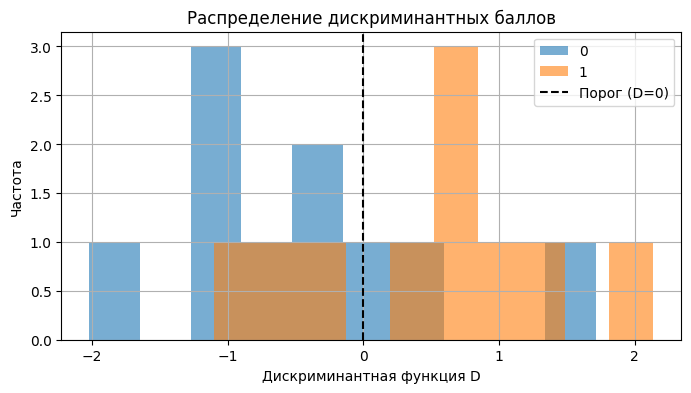

In [52]:
# --- Кросс-валидация ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lda, X_scaled, y, cv=cv, scoring='accuracy')

print(f"\n🔍 Кросс-валидация (5-fold):")
print(f"Точность: {scores.mean():.3f} ± {scores.std():.3f}")

# --- Матрица ошибок на всей выборке ---
y_pred = lda.predict(X_scaled)
print("\n📋 Матрица классификации (обучающая выборка):")
print(pd.crosstab(y, y_pred, rownames=['Факт'], colnames=['Прогноз']))
print("\nОтчёт по классификации:")
print(classification_report(y, y_pred))

# --- Визуализация дискриминантных баллов ---
plt.figure(figsize=(8, 4))
for group in np.unique(y):
    plt.hist(D_scores[y == group], alpha=0.6, label=f'{group}', bins=10)
plt.axvline(0, color='k', linestyle='--', label='Порог (D=0)')
plt.xlabel('Дискриминантная функция D')
plt.ylabel('Частота')
plt.title('Распределение дискриминантных баллов')
plt.legend()
plt.grid(True)
plt.show()